In [1]:
import torch
import torch.autograd as autograd
import autograd.numpy as np
from tqdm import tqdm, trange
import os
import numpy as np
import torch
from src.Tmy_svgd import tmySVGD
import torch.optim as optim
import torch.distributions as D
import pickle
import argparse
import time
import matplotlib.pyplot as plt
from src.svgd import SVGD
from src.gsvgd import FullGSVGDBatch
from src.kernel import RBF, BatchRBF
from src.utils import plot_particles

from src.manifold import Grassmann
from src.s_svgd import SlicedSVGD

/home/zhoujk/anaconda3/envs/AG/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
a = torch.zeros(10, 4)
a[1, 1] = 1
a

tensor([[0., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])

In [2]:
from src.Sliced_KSD_Clean.Util import *
from src.Sliced_KSD_Clean.Divergence.Def_Divergence import *
from src.Sliced_KSD_Clean.Divergence.Kernel import *
from src.Sliced_KSD_Clean.Divergence.Dataloader import *

import os
import numpy as np
import torch
import torch.optim as optim
import torch.distributions as D
from tqdm import tqdm, trange
from src.svgd import SVGD
from src.gsvgd import FullGSVGDBatch
from src.kernel import RBF, BatchRBF
from src.utils import plot_particles

from src.manifold import Grassmann
from src.s_svgd import SlicedSVGD
from src.mysvgd import mySVGD
import matplotlib.pyplot as plt

import pickle
import argparse
import time

import torch.autograd as autograd

In [3]:
parser = argparse.ArgumentParser(description='Running xshaped experiment.')
hao = 10 
parser.add_argument('--dim', type=int,default=10,help='dimension')
parser.add_argument('--effdim', type=int, default=3, help='dimension')
parser.add_argument('--lr', type=float,default=0.01,help='learning rate')
parser.add_argument('--lr_g', type=float, default=0.1, help='learning rate for g')
parser.add_argument('--delta', type=float,default=0.01, help='stepsize for projections')
parser.add_argument('--T', type=float, default=1e-4, help='noise multiplier for projections')
parser.add_argument('--nparticles', type=int, default=100, help='no. of particles')
parser.add_argument('--epochs', type=int,default=20000, help='no. of epochs')
parser.add_argument('--metric', type=str, default="energy", help='distance metric')
parser.add_argument('--noise', type=str, default="True", help='whether to add noise')
parser.add_argument('--kernel', type=str, default="rbf", help='kernel')
parser.add_argument('--gpu', type=int, default=1, help='gpu')
parser.add_argument('--seed', type=int, default=0, help='random seed') 
parser.add_argument('--suffix', type=str, default="", help='suffix for res folder')
parser.add_argument('--m', type=int, help='no. of projections')
parser.add_argument('--save_every', type=int, default=200, help='step intervals to save particles')
parser.add_argument('--method', type=str, default="all", help='which method to use')

_StoreAction(option_strings=['--method'], dest='method', nargs=None, const=None, default='all', type=<class 'str'>, choices=None, required=False, help='which method to use', metavar=None)

In [4]:
args = parser.parse_args([])
dim = args.dim
lr = args.lr
delta = args.delta
T = args.T
nparticles = args.nparticles
epochs = args.epochs
seed = args.seed
eff_dims = [args.effdim] if args.effdim > 0 else [1, 2, 5]
add_noise = True if args.noise == "True" else False
correlation = 0.95
save_every = args.save_every
print(f"Running for dim: {dim}, lr: {lr}, nparticles: {nparticles}")


Running for dim: 10, lr: 0.01, nparticles: 100


In [5]:
device = torch.device(f'cuda:{args.gpu}' if args.gpu != -1 else 'cpu')
device

device(type='cuda', index=1)

In [6]:
def xshaped_gauss_experiment(mixture_dist, means, correlation):
    '''Mixture of Multivariate gaussian with cov matrices being the identity.
    Args:
        mixture_dist: torch.distributions.Categorical-like instance for the 
            probability of each component in the mixture.
        means: Tensor of shape (nmix, d), where nmix is the number of components 
            and d is the dimension of each component.
        correlation: Float between 0 and 1 for the magnitude of correlation between
            the first two dims.
    '''
    nmix, dim = means.shape
    
    # create multibatch multivariate Gaussian
    cov1 = torch.eye(dim, device=device)
    cov1[:2, :2] = torch.Tensor([[1, correlation], [correlation, 1]])
    cov2 = torch.eye(dim, device=device)
    cov2[:2, :2] = torch.Tensor([[1, -correlation], [-correlation, 1]])
    mix_cov = torch.stack((cov1, cov2))
    comp = D.MultivariateNormal(means.to(device), mix_cov)

    distribution = D.mixture_same_family.MixtureSameFamily(mixture_dist, comp)   
    return(distribution)

In [7]:
metric = args.metric

results_folder = f"./res/xshaped{args.suffix}/{args.kernel}_epoch{epochs}_lr{lr}_delta{delta}_n{nparticles}_dim{dim}"
results_folder = f"{results_folder}/seed{seed}"

In [8]:
if not os.path.exists(results_folder):
    os.makedirs(results_folder)

In [9]:
if args.kernel == "rbf":
    Kernel = RBF
    BatchKernel = BatchRBF

Device: cuda:1
Running SVGD


100%|██████████| 20000/20000 [01:03<00:00, 316.23it/s]
/home/zhoujk/anaconda3/envs/AG/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1666643016022/work/aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


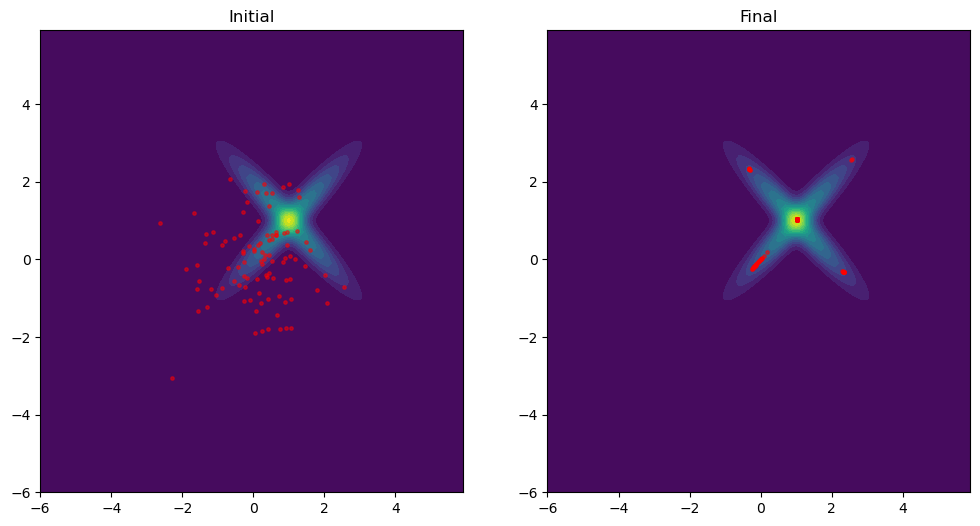

In [10]:
print(f"Device: {device}")
torch.manual_seed(seed)

## target density
mix_means = torch.zeros((2, dim), device=device)
mix_means[:, :2] = 1

distribution = xshaped_gauss_experiment(
    mixture_dist=D.Categorical(torch.ones(mix_means.shape[0], device=device)),
    means=mix_means,
    correlation=correlation
)

# sample from target (for computing metric)
x_target = distribution.sample((nparticles, ))
# sample from variational density
x_init = torch.randn(nparticles, *distribution.event_shape, device=device)



## SVGD
if args.method in ["SVGD", "all"]:
    print("Running SVGD")
    # sample from variational density
    x = x_init.clone().to(device)
    kernel = Kernel(method="med_heuristic")
    svgd = SVGD(distribution, kernel, optim.Adam([x], lr=lr), device=device)
    start = time.time()
    svgd.fit(x, epochs, verbose=True, save_every=save_every)
    elapsed_time_svgd = time.time() - start

    # plot particles
    fig_svgd = plot_particles(
        x_init.detach(), 
        x.detach(), 
        distribution, 
        d=6.0, 
        step=0.1, 
        concat=mix_means[0, 2:],
        savedir=results_folder + f"/svgd.png"
    )

In [11]:
print("Running mySVGD")

def score(X):
        X_cp = X.clone().detach().requires_grad_()
        log_prob = distribution.log_prob(X_cp)
        score_func = autograd.grad(log_prob.sum(), X_cp)[0]
        return score_func


# sample from variational density
res = []
rres = []
steps = []
lr = 0.01
x0 = x_init
vector1  = torch.randn(nparticles, dim).to(device)

for i in trange(100):
    
    theta, vector = mySVGD().update(x0, score,  k = 2, n_iter = 100,  debug = False, lr= lr, vector=vector1, device=device)
    #mean = np.mean(theta, axis=0)  + np.random.random(1)
    #var_theta = np.cov(theta.T) + np.random.random(1)
    #x0 = np.random.multivariate_normal(mean, var_theta,num)
    x0 = theta
    vector1 = vector

Running mySVGD


100%|██████████| 100/100 [14:07<00:00,  8.48s/it]


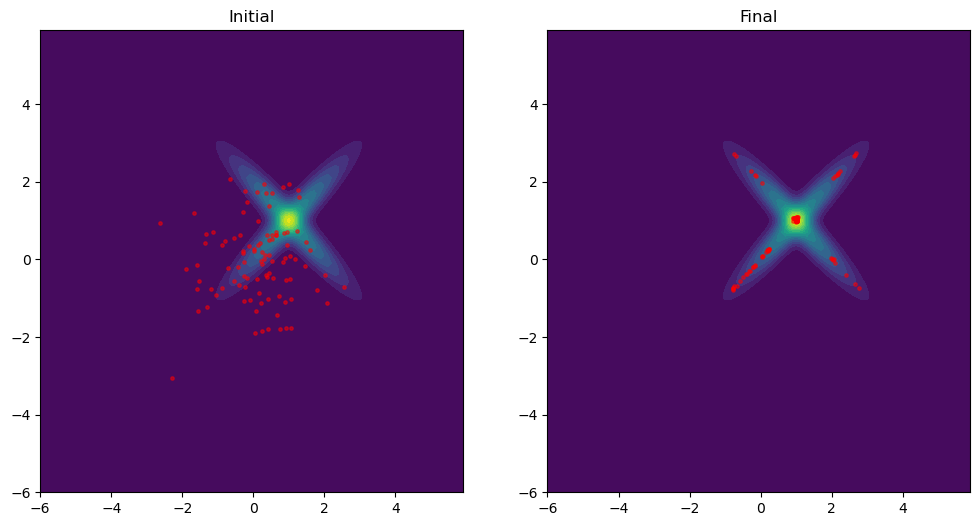

In [12]:
fig_svgd = plot_particles(
        x_init.detach(), 
        theta.detach(), 
        distribution, 
        d=6.0, 
        step=0.1, 
        concat=mix_means[0, 2:]
)

In [13]:
print("Running tmySVGD")

def score(X):
        X_cp = X.clone().detach().requires_grad_()
        log_prob = distribution.log_prob(X_cp)
        score_func = autograd.grad(log_prob.sum(), X_cp)[0]
        return score_func


# sample from variational density
res = []
rres = []
steps = []
lr = 0.005
x0 = x_init
vector1  = torch.randn(nparticles, dim).to(device)

for i in trange(100):
    
    theta, vector = tmySVGD(kernel).update(x0, score,  k = 2, n_iter = 50,  debug = False, lr= lr, vector=vector1)
    #mean = np.mean(theta, axis=0)  + np.random.random(1)
    #var_theta = np.cov(theta.T) + np.random.random(1)
    #x0 = np.random.multivariate_normal(mean, var_theta,num)
    x0 = theta
    vector1 = vector

Running tmySVGD


100%|██████████| 100/100 [07:00<00:00,  4.21s/it]


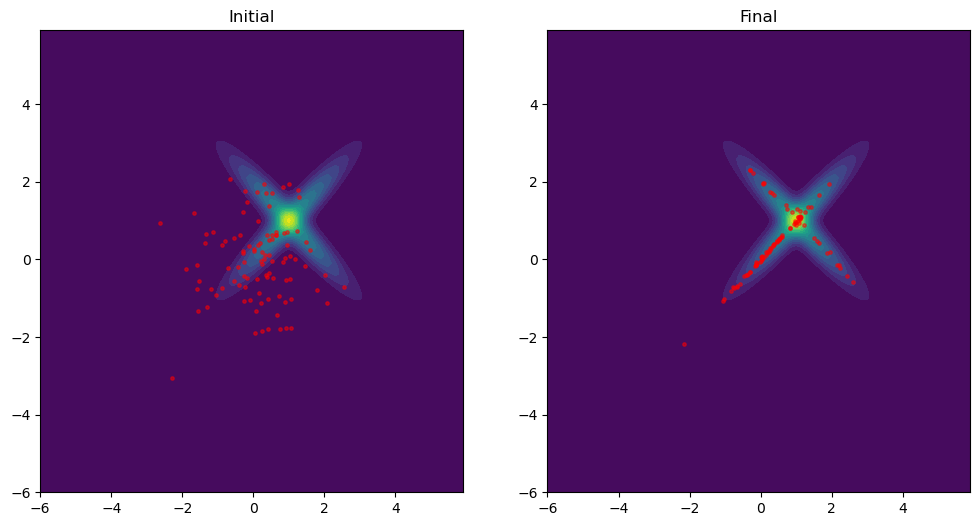

In [14]:
fig_svgd = plot_particles(
        x_init.detach(), 
        theta.detach(), 
        distribution, 
        d=6.0, 
        step=0.1, 
        concat=mix_means[0, 2:]
)

Running GSVGD with eff dim = 3
number of projections: 3


  5%|▍         | 995/20000 [00:14<04:37, 68.56it/s]/home/zhoujk/SVGD/SVGD_code/GSVGD-main/src/gsvgd.py:262: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'complete') (Triggered internally at /opt/conda/conda-bld/pytorch_1666643016022/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:2349.)
  A, _ = torch.qr(A)
100%|██████████| 20000/20000 [05:02<00:00, 66.21it/s]


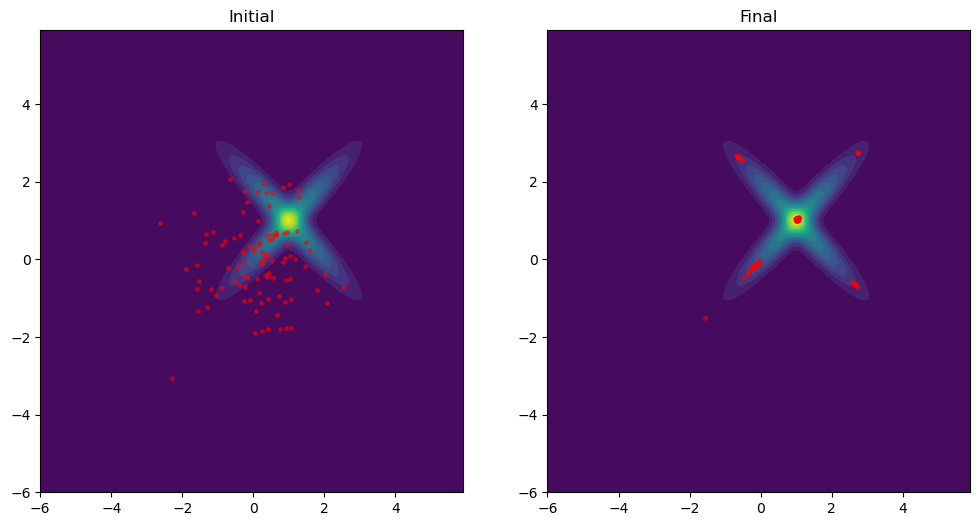

In [15]:
if args.method in ["GSVGD", "all"]:
    res_gsvgd = [0] * len(eff_dims)
    def run_gsvgd(eff_dims):
        for i, eff_dim in enumerate(eff_dims):
            print(f"Running GSVGD with eff dim = {eff_dim}")

            m = min(20, dim // eff_dim) if args.m is None else args.m
            print("number of projections:", m)

            # sample from variational density
            x_init_gsvgd = x_init.clone()
            x_gsvgd = x_init_gsvgd.clone()

            kernel_gsvgd = BatchKernel(method="med_heuristic")
            optimizer = optim.Adam([x_gsvgd], lr=lr)
            manifold = Grassmann(dim, eff_dim)
            U = torch.eye(dim, device=device).requires_grad_(True)
            U = U[:, :(m*eff_dim)]

            gsvgd = FullGSVGDBatch(
                target=distribution,
                kernel=kernel_gsvgd,
                manifold=manifold,
                optimizer=optimizer,
                delta=delta,
                T=T,
                device=device,
                noise=add_noise
            )
            start = time.time()
            U, metric_gsvgd = gsvgd.fit(x_gsvgd, U, m, epochs, 
                verbose=True, save_every=save_every, threshold=0.0001*m)
            elapsed_time = time.time() - start

            # plot particles
            fig_gsvgd = plot_particles(
                x_init_gsvgd.detach(), 
                x_gsvgd.detach(), 
                distribution, 
                d=6.0, 
                step=0.1, 
                concat=mix_means[0, 2:].to(device),
                savedir=results_folder + f"/fullgsvgd_effdim{eff_dim}_lr{lr}_delta{delta}_m{m}_T{T}.png"
            )

            # store results
            res_gsvgd[i] = {
                "init":x_init_gsvgd, "final":x_gsvgd, "metric":metric_gsvgd, 
                "fig":fig_gsvgd, "particles":gsvgd.particles, "pam":gsvgd.pam, "res": gsvgd,
                "elapsed_time": elapsed_time}
        return res_gsvgd

    res_gsvgd = run_gsvgd(eff_dims)

Running S-SVGD


100%|██████████| 20000/20000 [02:31<00:00, 132.15it/s]


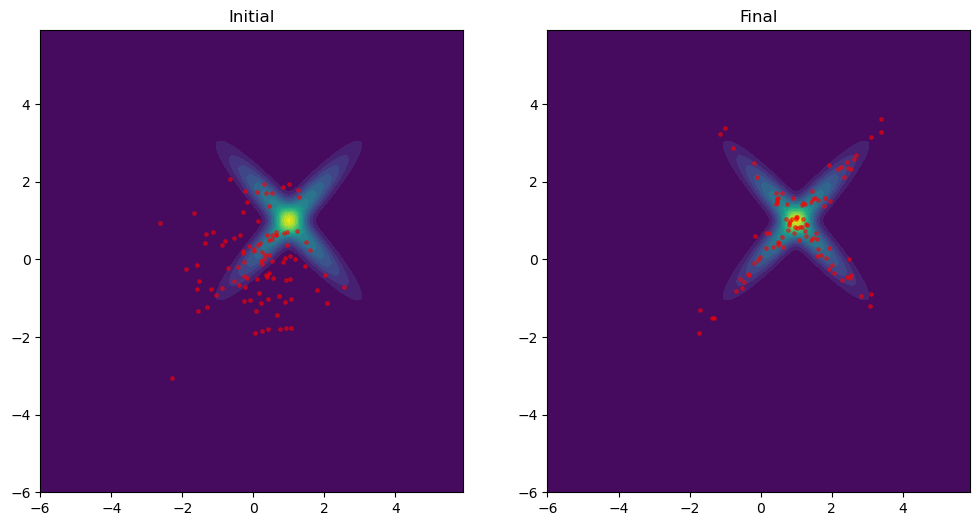

: 

In [16]:
if args.method in ["S-SSVGD", "all"]:
    # sample from variational density
    print("Running S-SVGD")
    x_init_s_svgd = x_init.clone()
    x_s_svgd = x_init_s_svgd.clone().requires_grad_()
    s_svgd = SlicedSVGD(distribution, device=device)

    start = time.time()
    x_s_svgd, metric_s_svgd = s_svgd.fit(
        samples=x_s_svgd, 
        n_epoch=epochs, 
        lr=args.lr_g,
        eps=lr,
        save_every=save_every
    )
    elapsed_time_s_svgd = time.time() - start

    # plot particles
    fig_s_svgd = plot_particles(
        x_init_s_svgd.detach(), 
        x_s_svgd.detach(), 
        distribution, 
        d=6.0, 
        step=0.1, 
        concat=mix_means[0, 2:],
        savedir=results_folder + f"/ssvgd_lr{lr}_lrg{args.lr_g}.png"
    )


## save results and figs
# time
elapsed_time = {
    **{"svgd": elapsed_time_svgd},
    **{f"gsvgd_effdim{d}": r["elapsed_time"] for d, r in zip(eff_dims, res_gsvgd)},
    **{"s_svgd": elapsed_time_s_svgd},
}

# particles
particles_epochs = np.arange(0, epochs+save_every, save_every)
pickle.dump(
    {
        **{"epochs": particles_epochs},
        **{"effdims": eff_dims},
        **{"target": x_target.cpu()},
        **{"svgd": svgd.particles},
        **{f"gsvgd_effdim{d}": r["particles"] for d, r in zip(eff_dims, res_gsvgd)},
        **{"s_svgd": s_svgd.particles},
        **{"elapsed_time": elapsed_time}
    },
    open(results_folder + "/particles.p", "wb")
)

# target distribution
torch.save(distribution, results_folder + '/target_dist.p')